2024-07-16 01:16:23.007849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 01:16:23.008031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 01:16:23.157397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9122 - loss: 0.2863 - val_accuracy: 0.9881 - val_loss: 0.0375
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9865 - loss: 0.0423 - val_accuracy: 0.9880 - val_loss: 0.0344
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9913 - loss: 0.0274 - val_accuracy: 0.9913 - val_loss: 0.0257
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9945 - loss: 0.0181 - val_accuracy: 0.9905 - val_loss: 0.0248
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 0.9907 - val_loss: 0.0287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


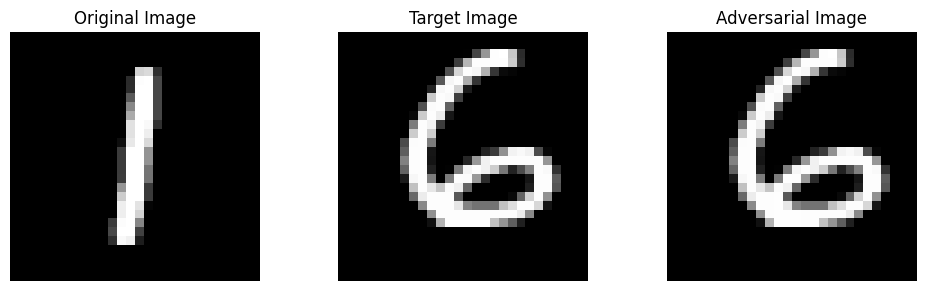

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Original Image Prediction: 1
Adversarial Image Prediction: 6


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

# Define the Boundary Attack
def boundary_attack(model, original_image, target_image, num_steps=1000, epsilon=0.01):
    adv_image = target_image.copy()
    for i in range(num_steps):
        # Calculate the difference between the adversarial and original image
        delta = adv_image - original_image
        # Scale the perturbation to be of unit length
        delta = delta / np.linalg.norm(delta.flatten())
        # Take a small step towards the original image
        adv_image = adv_image - epsilon * delta
        # Clip the adversarial image to be within valid pixel range
        adv_image = np.clip(adv_image, 0, 1)
        # Check if the adversarial image is misclassified
        if np.argmax(model.predict(adv_image.reshape(1, 28, 28, 1))) != np.argmax(model.predict(original_image.reshape(1, 28, 28, 1))):
            break
    return adv_image

# Select a random image from the test set and create a target image
np.random.seed(42)
original_index = np.random.randint(0, len(x_test))
target_index = np.random.randint(0, len(x_test))
original_image = x_test[original_index]
target_image = x_test[target_index]

# Generate the adversarial image
adv_image = boundary_attack(model, original_image, target_image)

# Visualize the original, target, and adversarial images
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_image.reshape(28, 28), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Target Image')
plt.imshow(target_image.reshape(28, 28), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Adversarial Image')
plt.imshow(adv_image.reshape(28, 28), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print predictions for original and adversarial images
original_pred = np.argmax(model.predict(original_image.reshape(1, 28, 28, 1)))
adv_pred = np.argmax(model.predict(adv_image.reshape(1, 28, 28, 1)))

print(f'Original Image Prediction: {original_pred}')
print(f'Adversarial Image Prediction: {adv_pred}')